In [1]:
import os
from datetime import datetime as dt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datagenic_rest_client.datagenic import DataGenic
from tshistory.api import timeseries
import matplotlib.pyplot as plt
from DG import get_prices_df

datagenic_rest_server = "http://lon-qdev-ap11"
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')

d = DataGenic(
    url_rest_wrapper=datagenic_rest_server, datagenic_url=os.environ["datagenicserver"],
  datagenic_username=os.environ["datagenicusername"], datagenic_password=os.environ["datagenicpassword"])

### does DFL lead spread, or spread lead DFL

In [2]:
model_dict = {
    'brentm1':"model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M01",
    'brentm2':"model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M02",
    'brentm6':"model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M06",
    'dfl':"model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_DTFRT.M01/MID/ALL"
    }

df = get_prices_df(model_dict, dt(2000,1,1)).dropna()
df['brentm1_m2'] = df['brentm1'] - df['brentm2']
data = df.drop(columns=['brentm1','brentm2','brentm6'])
# df['brentm1_m6'] = df['brentm1'] - df['brentm6']
# data = df.drop(columns=['brentm1','brentm2','brentm6'])

In [ ]:
diff = data.diff()
df_W = data.resample('W').mean()

### Causailty and correlation analysis

In [3]:
col = 'brentm1_m2'

In [ ]:
model = sm.tsa.VAR(endog=data.resample('W-Fri').last().diff().dropna()).fit()
model.irf().plot()
# print(model.test_causality('dfl', ['brentm1_m2'], kind='f').summary(), model.test_causality('brentm1_m2', ['dfl'], kind='f').summary())
print(model.test_causality('dfl', [col], kind='f').summary(), model.test_causality(col, ['dfl'], kind='f').summary())

In [ ]:
import statsmodels.api as sm
model = sm.tsa.VAR(endog=data.resample('W-Fri').last().diff().dropna()).fit()
model.irf().plot_cum_effects()
model.test_causality('dfl', [col], kind='f').summary(), model.test_causality(col, ['dfl'], kind='f').summary()

### Trade strategy

In [4]:
def get_sharpe(df,x,y,z):
    sharpe_x = df['PnL'].rolling(x).mean()/df['PnL'].std()
    sharpe_y = df['PnL'].rolling(y).mean()/df['PnL'].std()
    sharpe_z = df['PnL'].rolling(z).mean()/df['PnL'].std()
    fig, ax = plt.subplots(nrows=3, figsize=(10,10))
    sharpe_x.plot(kind='area', stacked=False, ax=ax[0], title=f'rolling {x} / {y} / {z} week rolling sharpe ratio')
    sharpe_y.plot(kind='area', stacked=False, ax=ax[1])
    sharpe_z.plot(kind='area', stacked=False, ax=ax[2])

In [5]:
def create_df(data, func):
    df_scaled = pd.concat([data.resample('w-fri').first(),data.resample('w-fri').last()], axis=1)
    df_scaled.columns = ['dfl_open', 'spread_open', 'dfl_close', 'spread_close']
    df_scaled['spread-mean'] = data[col].resample('w-fri').mean()
    df_scaled['dfl-change'] = df_scaled['dfl_close'] - df_scaled['dfl_open'] 
    df_scaled['spread-change'] = df_scaled['spread_close'] - df_scaled['spread_open']
    df_scaled['spread-change-fcast'] = 0.3*df_scaled['dfl-change']
    df_scaled['position'] = df_scaled.apply(func, axis=1).shift(1)
    df_scaled['PnL'] = df_scaled['position']*df_scaled['spread-change']
    # columns for information
    df_scaled['spread-change-w-1'] = df_scaled['spread-change'].shift(1)
    df_scaled['spread-change-fcast-w-1'] = df_scaled['spread-change-fcast'].shift(1)
    return df_scaled                                                             

naive DFL to brent model

In [63]:
def basic_func(x):
    if x['dfl-change']>0:
        return 100000
    else: 
        return -100000

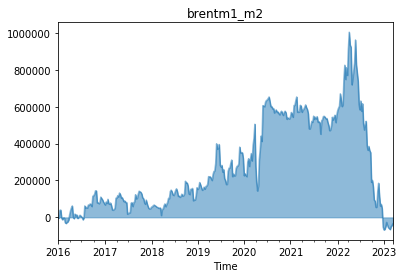

In [66]:
df_simple = create_df(data,basic_func)
df_simple['PnL'].loc['2016':].cumsum().plot(kind='area', stacked=False, title=col)

In [ ]:
get_sharpe(df, 12, 52, 104)

### binary scaled strategy

In [6]:
# binary
def binary_func(df):
    if df['spread-change'] < df['spread-change-fcast'] and df['dfl-change']>0:
        return 100000
    elif df['spread-change'] > df['spread-change-fcast'] and df['dfl-change']<0:
        return -100000
    else:
        return 0

In [60]:
df_scaled = create_df(data,binary_func)
# df_scaled = strip_events(create_df(data,binary_func))

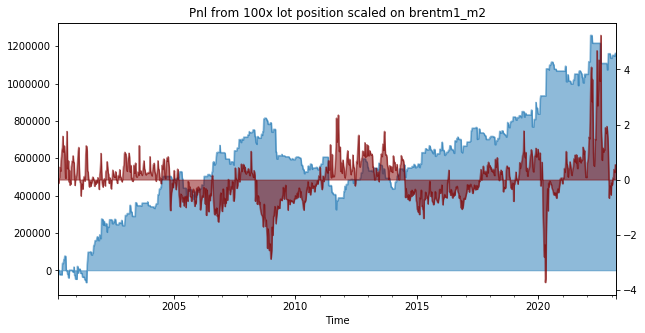

In [61]:
# df_scaled['PnL'].loc['2008':].cumsum().plot(kind='area', stacked=False)
ax = df_scaled['PnL'].cumsum().plot(kind='area', stacked=False, title=f'Pnl from 100x lot position scaled on {col}', figsize=(10,5))
ax2 = ax.twinx()
df_scaled['spread-mean'].plot(kind='area',stacked=False, ax=ax2, color='maroon')

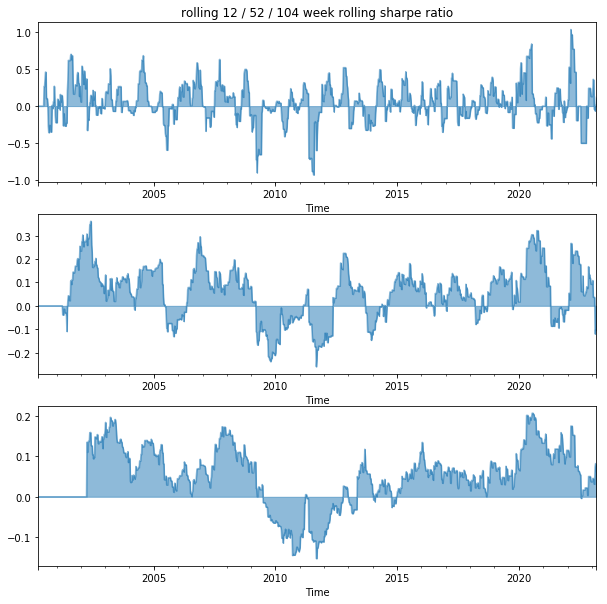

In [43]:
get_sharpe(df_scaled,12,52,104)

### scaled by magnitude

In [12]:
# lower sharpe ratio, not correct
# def func(df):
#     if df['spread-change'] < df['spread-change-fcast'] and df['dfl-change']>0:
#         return (df['spread-change-fcast'] - df['spread-change'])*100000
#     elif df['spread-change'] > df['spread-change-fcast'] and df['dfl-change']<0:
#         return (df['spread-change'] - df['spread-change-fcast'])*100000
#     else:
#         return 0

In [16]:
# problem is when spread change negative and moves further than fcast, i.e. spread move -100, dfl move -10, singal becomes +90
# but is this a problem.. maybe not
def func(df):
    return (df['spread-change-fcast']-df['spread-change'])*100000

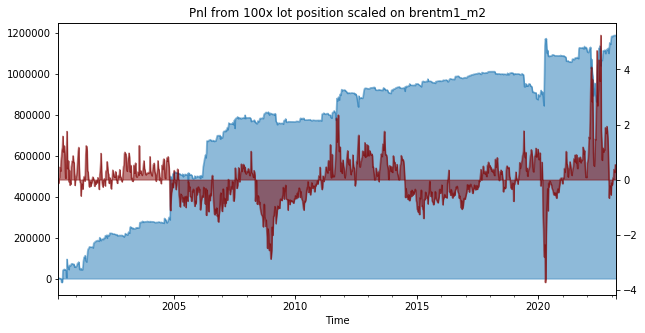

In [37]:
df_scaled = create_df(data, func)
ax = df_scaled['PnL'].cumsum().plot(kind='area', stacked=False, title=f'Pnl from 100x lot position scaled on {col}', figsize=(10,5))
ax2 = ax.twinx()
df_scaled['spread-mean'].plot(kind='area',stacked=False, ax=ax2, color='maroon')

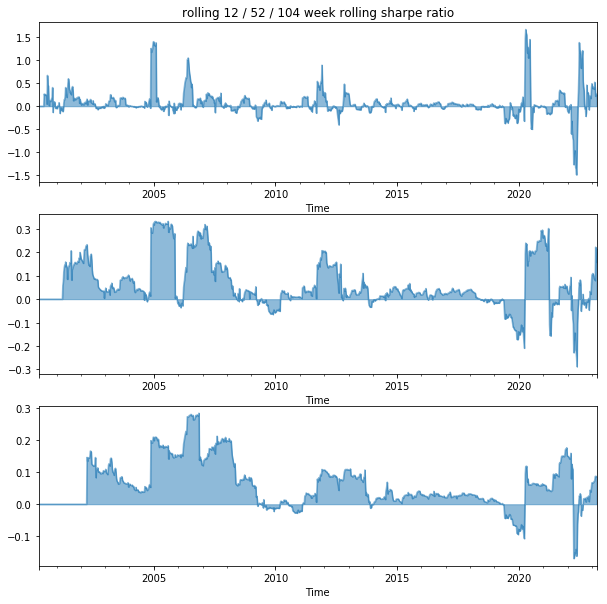

In [18]:
get_sharpe(df_scaled,12,52,104)

In [ ]:
df_scaled.head()

In [ ]:
# biggest gains and losses
df_scaled['sharpe'] = df_scaled['PnL']/df_scaled['PnL'].std()
gains = df_scaled[df_scaled['sharpe']>1]
losses = df_scaled[df_scaled['sharpe']<-1]
# writer = pd.ExcelWriter('gains_losses.xlsx', engine='xlsxwriter')
# gains.to_excel(writer, sheet_name='gains')
# losses.to_excel(writer, sheet_name='losses')
# writer.save()

In [ ]:
# df_scaled.head(20)
# df_scaled.head(20).style.background_gradient('RdBu', axis=1)

In [ ]:
# biggest losses
gains.sort_values(by='sharpe', ascending=False).head(10)

### strip out covid / war

In [85]:
def strip_events(df):
    msk_2020 = df.loc['2020'].index
    msk_2022 = df.loc['2022'].index
    return df.drop(msk_2020).drop(msk_2022)

def backwardated_model(df):
    msk = df[df['spread-mean']<0].index
    return df.drop(msk)

def contango_model(df):
    msk = df[df['spread-mean']>0].index
    return df.drop(msk)

def rally(df):
    df['spread-rolling-mean'] = df['spread-change'].rolling(4).mean()
    msk = df[df['spread-rolling-mean']<0].index
    return df.drop(msk)

def sell_off(df):
    df['spread-rolling-mean'] = df['spread-change'].rolling(4).mean()
    msk = df[df['spread-rolling-mean']>0].index
    return df.drop(msk)

In [77]:
df_stripped

dfl_open  spread_open  dfl_close  spread_close  spread-mean  \
Time                                                                      
2000-04-07    -0.090        -0.07     -0.345         -0.26      -0.1440   
2000-04-14    -0.355        -0.28     -0.160         -0.03      -0.1200   
2000-04-21    -0.140         0.03     -0.165          0.08       0.0525   
2000-04-28    -0.220        -0.04     -0.055          0.19       0.0800   
2000-05-05     0.115         0.37      0.150          0.39       0.4525   
...              ...          ...        ...           ...          ...   
2023-02-10    -0.460         0.28     -0.280          0.40       0.3660   
2023-02-17    -0.360         0.38     -0.570          0.33       0.3320   
2023-03-03    -0.240         0.41     -0.100          0.57       0.5400   
2023-03-10    -0.140         0.56     -0.140          0.62       0.5280   
2023-03-17    -0.130         0.54     -0.290          0.45       0.4950   

            dfl-change  spread-change  spread-change-fcast  position      PnL  \
Time                                                                            
2000-04-07      -0.255          -0.19              -0.0765       NaN      NaN   
2000-04-14       0.195           0.25               0.0585       0.0      0.0   
2000-04-21      -0.025           0.05              -0.0075       0.0      0.0   
2000-04-28       0.165           0.23               0.0495 -100000.0 -23000.0   
2000-05-05       0.035           0.02               0.0105       0.0      0.0   
...                ...            ...                  ...       ...      ...   
2023-02-10       0.180           0.12               0.0540       0.0      0.0   
2023-02-17      -0.210          -0.05              -0.0630       0.0     -0.0   
2023-03-03       0.140           0.16               0.0420  100000.0  16000.0   
2023-03-10       0.000           0.06               0.0000       0.0      0.0   
2023-03-17      -0.160          -0.09              -0.0480       0.0     -0.0   

            spread-change-w-1  spread-change-fcast-w-1  spread-rolling-mean  
Time                                                                         
2000-04-07                NaN                      NaN                  NaN  
2000-04-14              -0.19                  -0.0765                  NaN  
2000-04-21               0.25                   0.0585                  NaN  
2000-04-28               0.05                  -0.0075               0.0850  
2000-05-05               0.23                   0.0495               0.1375  
...                       ...                      ...                  ...  
2023-02-10              -0.17                  -0.0120               0.0825  
2023-02-17               0.12                   0.0540               0.0325  
2023-03-03               0.05                   0.0750               0.0700  
2023-03-10               0.16                   0.0420               0.0550  
2023-03-17               0.06                   0.0000               0.0450  

[668 rows x 13 columns]

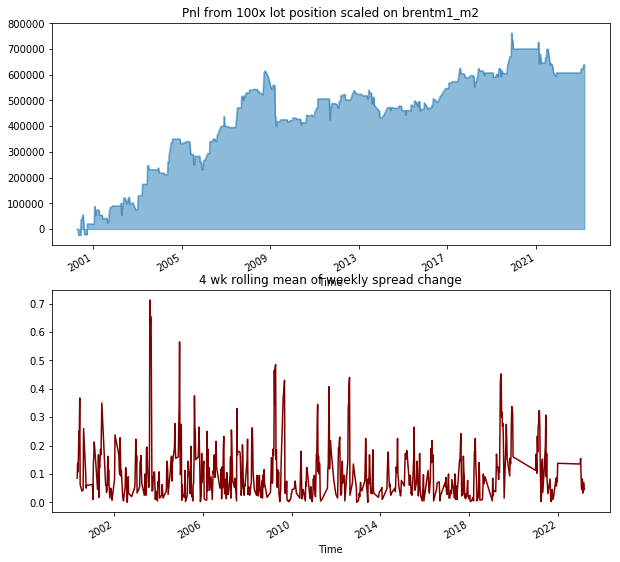

In [88]:
df_stripped = rally(strip_events(df_scaled))
fig, ax = plt.subplots(nrows=2)
df_stripped['PnL'].cumsum().plot(kind='area', stacked=False, title=f'Pnl from 100x lot position scaled on {col}', figsize=(10,10), ax=ax[0])
df_stripped['spread-rolling-mean'].plot(title= '4 wk rolling mean of weekly spread change',kind='line',stacked=False, ax=ax[1], color='maroon')

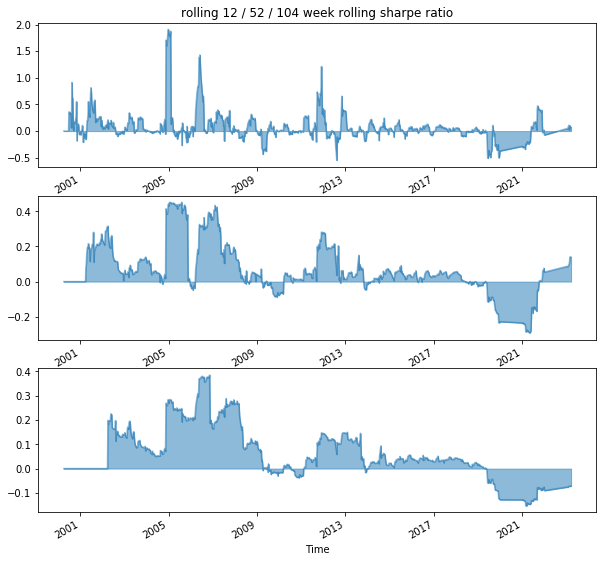

In [33]:
get_sharpe(df_stripped,12,52,104)

In [ ]:
# sharpe with VAR
sharpe_7 = df_scaled['PnL'].rolling(5).mean()/(df_scaled['spread-change']*100000).std()
sharpe_90 = df_scaled['PnL'].rolling(12).mean()/(df_scaled['spread-change']*100000).std()
sharpe_180 = df_scaled['PnL'].rolling(52).mean()/(df_scaled['spread-change']*100000).std()
sharpe_252 = df_scaled['PnL'].rolling(104).mean()/(df_scaled['spread-change']*100000).std()
fig, ax = plt.subplots(nrows=3, figsize=(10,10))
sharpe_90.plot(kind='area', stacked=False, ax=ax[0], title='rolling 12 / 52 / 104 week rolling sharpe ratio')
sharpe_180.plot(kind='area', stacked=False, ax=ax[1])
sharpe_252.plot(kind='area', stacked=False, ax=ax[2])

In [ ]:
pnl = df_scaled['PnL']
msk = pnl[pnl!=0]
msk.plot.hist(bins=100)

### latest trade ideas

In [ ]:
df_scaled.tail()

### charting

In [ ]:
fig, ax = plt.subplots(1)
df_W.plot(figsize=(20,5), ax=ax)
# ax2 = ax.twinx()
df_W.diff(axis=1).plot.area(figsize=(20,5), ax=ax, color='maroon', stacked=False)

In [ ]:
df['dfl'].plot.hist(bins=200)

In [ ]:
df.diff().head()

In [ ]:
# df.diff().plot().scatter(x='dfl',y='brentm1_m2')
sns.regplot(data=df.diff(),x='dfl',y='brentm1_m2')

In [ ]:
fig, ax = plt.subplots(2)
df.diff().plot().scatter(x='dfl',y='brentm1_m2', ax=ax[0])
df.diff().rolling(14).mean().plot(figsize=(20,5), ax=ax[1])

In [ ]:
df.cumsum().plot(figsize=(20,5))

### Cross correlation of wti-brent arb legs

In [ ]:
model_dict = {
    'wtim1':'model://ICE_WTI/EU.OIL.WTI.ICE.WTI.FUT.M01',
    'wtim2':'model://ICE_WTI/EU.OIL.WTI.ICE.WTI.FUT.M02',
    'wti_brent':"model://ICE_BRT_WTI_SP/EU.OIL.NSEA_WTI.ICE.BRENT_WTI.FUT.SP.M01",
    'TD7':'model://BALT_FFA/EU.FR.FFA.TD7_USD.BALTIC.M00',
    'brentm1':"model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M01",
    'brentm2':"model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M02",
    'dfl':"model://PLATTS_DR/PLATTS.PET.DR.FWD.BRENT_DTFRT.M01/MID/ALL"
    }

In [ ]:
df = get_prices_df(model_dict, dt(2017,1,1)).dropna()
outlier = df['wtim1']<0
df.drop(index=df[outlier].index, inplace=True)
df['brentm1_m2'] = df['brentm1'] - df['brentm2']
df['wtim1_m2'] = df['wtim1'] - df['wtim2']
df = df.drop(columns=['brentm1','brentm2','wtim1','wtim2'])

In [ ]:
g=sns.pairplot(df)
g.fig.set_size_inches(15,15)

### WTI fob NWE calculation

In [ ]:
start = dt(2020,1,1)
td7_m00 = d.get_time_series(model_url = "model://BALT_FFA/EU.FR.FFA.TD7_USD.BALTIC.M00", from_date=start, to_date=dt.today())
empty_list = []
for x in faf_list:
    y = d.get_time_series(model_url = x, from_date=start, to_date=dt.today())
    empty_list.append(y)

In [ ]:
fafs = pd.concat(empty_list,axis=1).mean(axis=1)
td7_bbl = td7_m00 * 0.133

In [ ]:
fig, ax = plt.subplots(1,figsize=(10,5))
corr['wti_fob'].plot(ax=ax, color='maroon')
ax2 = ax.twinx()
corr['net_length'].plot(ax=ax2)
ax.set_title(label='WTI FOB NWE')
ax.legend(['WTI', 'net_length'])

In [ ]:
wti_brent = d.get_time_series("model://ICE_BRT_WTI_SP/EU.OIL.NSEA_WTI.ICE.BRENT_WTI.FUT.SP.M01", from_date=dt(2010,1,1), to_date=dt.today())

In [ ]:
wti_brent_m = wti_brent.resample("MS").mean()

In [ ]:
# diff.to_frame()
corr_2010 = wti_brent_m.merge(diff.to_frame(), left_index=True, right_index=True)
corr_2010.columns = ['spread', 'net_length']

In [ ]:
corr_2010[corr_2010['spread']>10]

In [ ]:
sns.regplot(data=corr_2010.loc['2017-04-01':], x='spread', y='net_length')